In [1]:
import pandas as pd
import numpy as np
import ocel 
import os
import pprint
from prettytable import PrettyTable
from IPython.display import display
import pm4py
import scipy.signal
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import json
from ocpa.objects.log.importer.ocel import factory as ocel_import_factory
from pyclustering.cluster.optics import optics
from pylab import *
import itertools
from ocpa.algo.discovery.ocpn import algorithm as ocpn_discovery_factory
from ocpa.visualization.oc_petri_net import factory as ocpn_vis_factory
from ocpa.algo.predictive_monitoring import factory as predictive_monitoring
from ocpa.algo.predictive_monitoring import tabular, sequential
from collections import defaultdict
from sklearn.metrics import roc_auc_score, f1_score, average_precision_score, precision_score, recall_score

In [1]:
def anomaly_detection(targetDataset, minpoints, objecttype, data_ocel, eps, prominence):    
    #PARAMs#
    minpts = minpoints
    #eps = 20
    #prominence = 0.3
    d = {}
    Z = defaultdict(dict)
    remap_cids = []
    all_rels = []
    cids = []
    ocdfg = pm4py.discover_ocdfg(data_ocel)
    data = targetDataset
    target_objects = []
    for object in data['ocel:objects']:
        if data['ocel:objects'][object]['ocel:type'] == objecttype:
            target_objects.append(object)
    for object in target_objects:
        Z[object] = {}
    #for object in ocdfg['edges']['event_couples']:   
    for act_rel in ocdfg['edges']['event_couples'][objecttype]:
        z = defaultdict(dict)
        for e1, e2 in ocdfg['edges']['event_couples'][objecttype][act_rel]:
            for object in data['ocel:events'][e1]['ocel:omap']:
                if data['ocel:objects'][object]['ocel:type'] == objecttype:
                    cid = object
            if objecttype == 'offer':
                rel = act_rel
            else:
                a1 = data['ocel:events'][e1]['ocel:vmap']['event']
                a2 = data['ocel:events'][e2]['ocel:vmap']['event']
                rel = a1+"->"+a2
            
            #a1 = data['ocel:events'][e1]['ocel:vmap']['event'] #a1 = data['ocel:events'][e1]['ocel:vmap']['event'] or ['ocel:activity']
            t1 = pd.to_datetime(data['ocel:events'][e1]['ocel:timestamp'])
            #a2 = data['ocel:events'][e2]['ocel:vmap']['event'] #a2 = data['ocel:events'][e2]['ocel:vmap']['event'] or ['ocel:activity']
            t2 = pd.to_datetime(data['ocel:events'][e2]['ocel:timestamp'])
            #rel = a1+"->"+a2
            
            diff = (t2 - t1).total_seconds()
            if rel in d:
                d[rel].append(diff)
            else:
                d[rel] = [diff]
            #z[rel] = diff
            # if rel in Z[cid][z]:
            #     Z[cid][z].update({rel: diff})
            # else:
            #     Z[cid][z][rel] = diff
            Z[cid][rel] = diff
            #Z[tid] = {rel: [diff]}
        #Z[act_rel] = z 
    avg = {}
    std = {}
    ext = {}

    for rel, values in d.items():
        avg[rel] = np.mean(values)
        std[rel] = np.std(values)
        ext[rel] = np.max(np.abs(values))
        

    rels = list(d.keys())


    test_time = []

        
    # standardizing
    Zstd = {}
    for cid, trace in Z.items():
        vstd = {}
        for rel, value in trace.items():
            vstd[rel] = (value-avg[rel])
            if std[rel] == 0:
                vstd[rel] = 0
            else:
                vstd[rel] /= std[rel]
        Zstd[cid] = vstd
        
    cids = Z.keys()

    Zvectors = []

    for cid in cids:
        
        temp = Zstd[cid]
        dummy = []
        for rel in rels:
            if rel in temp:
                dummy.append(temp[rel])
            else:
                dummy.append(0.0)
        Zvectors.append(dummy)
        remap_cids.append(cid)



    print("Number of traces: ", len(Zvectors))
    print("Number of relations: ", len(rels))

    optics_instance = optics(Zvectors, eps, minpts)

    optics_instance.process()

    clusters = optics_instance.get_clusters()
    noise = optics_instance.get_noise()

    reach = pd.Series(optics_instance.get_ordering())
    left = max(reach)

    reach_smoothed = scipy.signal.savgol_filter(reach, 5, 3)

    if(len(reach)%2 == 0):
        l = len(reach)-1
    else:
        l = len(reach)-2

    yhat = scipy.signal.savgol_filter(reach, l, 3)



    coord1 = [np.array((x,reach_smoothed[x])) for x in range(len(reach_smoothed))]
    coord2 = [np.array((x,yhat[x])) for x in range(len(yhat))]


    diffy = (yhat-reach_smoothed)*yhat


    yhatclip = np.clip(diffy, 0, np.max(diffy))


    peaks, properties = find_peaks(yhatclip, prominence=prominence, width=minpts/2.0)


    cc = {}
    cluster_objects_ids = {}
    entropy_all = {}

    outliers_list = []

    clusters = [val for sublist in clusters for val in sublist]

    for k in range(len(peaks)):
        left = np.ceil(properties["left_ips"][k])
        right = np.floor(properties["right_ips"][k])
        cc[k] = [clusters[l] for l in range(int(left),int(right))]
        
        outliers_list.extend(cc[k])
        cluster = [Zvectors[l] for l in cc[k]]
        
        cluster_objects_ids[k] = [remap_cids[o] for o in cc[k]]
        
        entropies = []
        for i in range(len(rels)):
            rel = rels[i]
            e = np.std([v[i] for v in cluster])
            mean = np.mean([v[i] for v in cluster])
            
            entropies.append((e,rel, mean))
            
        entropy_all[k] = entropies
        
    fig, ax1 = plt.subplots(figsize=(8,2))
    #fig = plt.figure(figsize=(8, 4), dpi=dpi)

    plt.plot(reach_smoothed)
    plt.plot(yhat, color='red')

    if len(peaks) == 1:
        xs = np.arange(int(properties["left_ips"]), int(properties["right_ips"]), 1)
        ax1.fill_between(xs, reach_smoothed[int(properties["left_ips"]):int(properties["right_ips"])], yhat[int(properties["left_ips"]):int(properties["right_ips"])], color='00', alpha=0.3)
    elif len(peaks) > 1:
        for i in range(len(peaks)):
            xs = np.arange(int(properties["left_ips"][i]), int(properties["right_ips"][i]), 1)
            ax1.fill_between(xs, reach_smoothed[int(properties["left_ips"][i]):int(properties["right_ips"][i])], yhat[int(properties["left_ips"][i]):int(properties["right_ips"][i])], color='00', alpha=0.3) 
    #plt.vlines(x=peaks, ymin=reach_smoothed[peaks], ymax = yhat[peaks], color = "C1")
    #plt.hlines(y=reach_smoothed[peaks], xmin=properties["left_ips"], xmax=properties["right_ips"], color = "C1")
    plt.title('TOAD plot')
    plt.ylabel('Reachability Distance')
    plt.xlabel('Traces')
    plt.show()
    #print(cluster_objects_ids)
    predicted_anomalies = []
    for x in cluster_objects_ids.keys():
        for entry in cluster_objects_ids[x]:
            predicted_anomalies.append(entry)
    return predicted_anomalies
        

In [3]:
def txt_to_list(filepath):    
    # opening the file in read mode 
    my_file = open(filepath, "r") 
    
    # reading the file 
    anomalycids = my_file.read() 
    
    # replacing end splitting the text  
    # when newline ('\n') is seen. 
    anomalycids_list = anomalycids.split("\n")
    for x in anomalycids_list:
        if x == '':
            anomalycids_list.remove(x) 
    my_file.close()
    return anomalycids_list 

In [4]:
def listCaseIds(targetDataset):   
    caseIDs = []
    for event in targetDataset['ocel:events']:
        caseIDs.append(targetDataset['ocel:events'][event]['ocel:vmap']['cID'])
    caseIDs = list(set(caseIDs)) 
    return caseIDs       

In [5]:
def listObjectIds(targetDataset, ocel): 
    object_type = pm4py.ocel_get_object_types(ocel)[0] 
    objectIDs = []
    for object in targetDataset['ocel:objects']:
        if targetDataset['ocel:objects'][object]['ocel:type'] == object_type:
            objectIDs.append(object)
    objectIDs = list(set(objectIDs)) 
    return objectIDs     

In [ ]:
def metrics(data_filepath, anomaly_filepath, eps, prom):    
    data_ocel = pm4py.read_ocel(data_filepath)
    with open(data_filepath, 'r') as file:
        targetDataset = json.load(file)
    anomalyobjects_list = txt_to_list(anomaly_filepath)
    #ocdfg = pm4py.discover_ocdfg(bpi15)
    #Parameters
    minpoints = [5, 10, 15, 20, 25] #[2, 4, 5, 10] #[5, 15, 20, 25, 30, 35, 40, 45]
    objecttype = pm4py.ocel_get_object_types(data_ocel)[0] #'Application' 'offer'
    #true labels
    y_true = []
    #list of all case ids
    cids = listObjectIds(targetDataset, data_ocel)
    for cid in cids:
        if str(cid) in anomalyobjects_list:
            y_true.append(1)
        else:
            y_true.append(0)
    #counter depicting the number of times each case id has been identified as anomalous
    anomaly_counts = np.zeros(len(cids))
    #F1-Score for each minpoints value
    f1_scores = []
    precisionlist = []
    recalllist = []          
    for minPts in minpoints:
        predAnomalies = anomaly_detection(targetDataset, minPts, objecttype, data_ocel, eps, prom)
        y_pred = []
        for cid in cids:
            if cid in predAnomalies:
                y_pred.append(1)
            else:
                y_pred.append(0)
        f1 = float(f1_score(y_true, y_pred))
        f1_scores.append(f1)
        precision = float(precision_score(y_true, y_pred))
        recall = float(recall_score(y_true, y_pred))
        anomaly_counts += y_pred
        print('F1-Score for minpts value ' + str(minPts) + ':' )
        display(f1)
        print('Precision-Score for minpts value ' + str(minPts) + ':' )
        display(precision)
        print('Precision-Score for minpts value ' + str(minPts) + ':' )
        display(recall)
        precisionlist.append(precision)
        recalllist.append(recall)
        #display(y_pred)
        #display(predAnomalies)
            
    #Normalize anomaly counts to get continuous anomaly scores for the auc calculations
    anomaly_scores = anomaly_counts / len(minpoints)
    #AUC ROC score
    rocauc = roc_auc_score(y_true, anomaly_scores)
    #AUC PR score
    aucpr = average_precision_score(y_true, anomaly_scores)
    #Mean of F1-Scores
    mean_f1 = np.mean(f1_scores)
    print('AUC ROC Score for minPTS [5, 15, 20, 25, 30, 35, 40, 45]: is: ')
    display(rocauc)
    print('AUC PR Score for minPTS [5, 15, 20, 25, 30, 35, 40, 45]: is: ')
    display(aucpr)
    print('Mean F1-Score for minPTS [5, 15, 20, 25, 30, 35, 40, 45]: is: ') 
    display(mean_f1)
    mean_precision = float(np.mean(precisionlist))
    mean_recall = float(np.mean(recalllist))
    results_dict = {'F1': round(mean_f1,2),
                    'AUC ROC': round(rocauc,2),
                    'AUC Precision-Recall': round(aucpr,2),
                    'Mean Precision' : round(mean_precision,2),
                    'Mean Recall' : round(mean_recall,2)
                    }
    results_df = pd.DataFrame([results_dict], index=[0])
    return results_df

Number of traces:  5000
Number of relations:  14


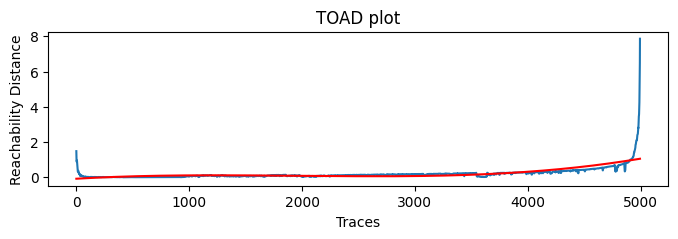

F1-Score for minpts value 5:


c:\Users\alper\hello\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.0

Precision-Score for minpts value 5:


0.0

Precision-Score for minpts value 5:


0.0

[]

Number of traces:  5000
Number of relations:  14


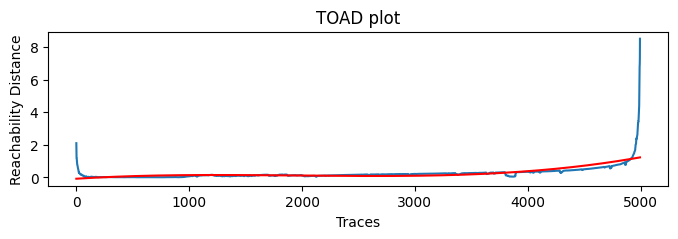

F1-Score for minpts value 10:


c:\Users\alper\hello\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.0

Precision-Score for minpts value 10:


0.0

Precision-Score for minpts value 10:


0.0

[]

Number of traces:  5000
Number of relations:  14


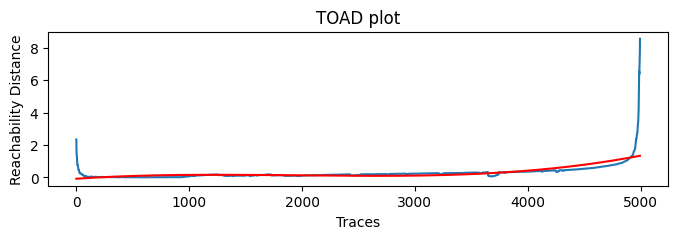

F1-Score for minpts value 15:


c:\Users\alper\hello\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.0

Precision-Score for minpts value 15:


0.0

Precision-Score for minpts value 15:


0.0

[]

Number of traces:  5000
Number of relations:  14


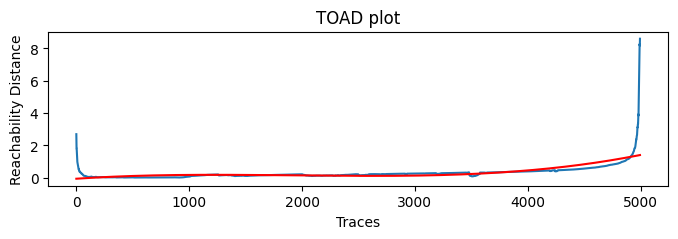

F1-Score for minpts value 20:


c:\Users\alper\hello\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.0

Precision-Score for minpts value 20:


0.0

Precision-Score for minpts value 20:


0.0

[]

Number of traces:  5000
Number of relations:  14


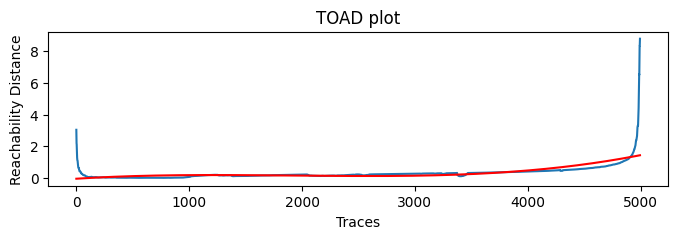

F1-Score for minpts value 25:


c:\Users\alper\hello\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.0

Precision-Score for minpts value 25:


0.0

Precision-Score for minpts value 25:


0.0

[]

AUC ROC Score for minPTS [5, 15, 20, 25, 30, 35, 40, 45]: is: 


np.float64(0.5)

AUC PR Score for minPTS [5, 15, 20, 25, 30, 35, 40, 45]: is: 


np.float64(0.0202)

Mean F1-Score for minPTS [5, 15, 20, 25, 30, 35, 40, 45]: is: 


np.float64(0.0)

In [37]:
ansatz3_bpi17_results = metrics('BPIC17_offer_first5000traces.jsonocel', 'BPIC17_offer_first5000traces_anomalous_app_objects.txt', 10, 1.2)

Number of traces:  1199
Number of relations:  85


C:\Users\alper\AppData\Local\Temp\ipykernel_9928\2836719356.py:164: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xs = np.arange(int(properties["left_ips"]), int(properties["right_ips"]), 1)
C:\Users\alper\AppData\Local\Temp\ipykernel_9928\2836719356.py:165: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax1.fill_between(xs, reach_smoothed[int(properties["left_ips"]):int(properties["right_ips"])], yhat[int(properties["left_ips"]):int(properties["right_ips"])], color='00', alpha=0.3)


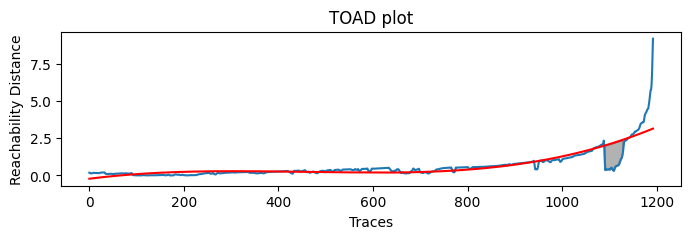

F1-Score for minpts value 5:


0.8604651162790697

Precision-Score for minpts value 5:


1.0

Precision-Score for minpts value 5:


0.7551020408163265

['48456',
 '48510',
 '49053',
 '49058',
 '49041',
 '48980',
 '49116',
 '48507',
 '49079',
 '48466',
 '48514',
 '48605',
 '48500',
 '48470',
 '48596',
 '48338',
 '48295',
 '48358',
 '48252',
 '48427',
 '48310',
 '48348',
 '48558',
 '48594',
 '49040',
 '49051',
 '48525',
 '48426',
 '48652',
 '48349',
 '49000',
 '48331',
 '48415',
 '48275',
 '48582',
 '48437',
 '49009']

Number of traces:  1199
Number of relations:  85


C:\Users\alper\AppData\Local\Temp\ipykernel_9928\2836719356.py:164: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xs = np.arange(int(properties["left_ips"]), int(properties["right_ips"]), 1)
C:\Users\alper\AppData\Local\Temp\ipykernel_9928\2836719356.py:165: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax1.fill_between(xs, reach_smoothed[int(properties["left_ips"]):int(properties["right_ips"])], yhat[int(properties["left_ips"]):int(properties["right_ips"])], color='00', alpha=0.3)


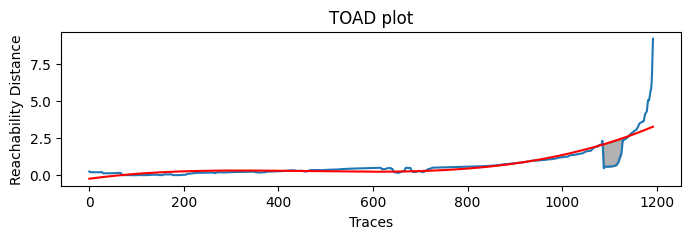

F1-Score for minpts value 10:


0.8863636363636364

Precision-Score for minpts value 10:


1.0

Precision-Score for minpts value 10:


0.7959183673469388

['48434',
 '48456',
 '48510',
 '49053',
 '49058',
 '49041',
 '48980',
 '49116',
 '48507',
 '48500',
 '48295',
 '48338',
 '49079',
 '48427',
 '48605',
 '48358',
 '48252',
 '48310',
 '48348',
 '48558',
 '48466',
 '49040',
 '48514',
 '48596',
 '48594',
 '49051',
 '48470',
 '48652',
 '48426',
 '48349',
 '49000',
 '48525',
 '48331',
 '48415',
 '48275',
 '48582',
 '48437',
 '49009',
 '48671']

Number of traces:  1199
Number of relations:  85


C:\Users\alper\AppData\Local\Temp\ipykernel_9928\2836719356.py:164: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xs = np.arange(int(properties["left_ips"]), int(properties["right_ips"]), 1)
C:\Users\alper\AppData\Local\Temp\ipykernel_9928\2836719356.py:165: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax1.fill_between(xs, reach_smoothed[int(properties["left_ips"]):int(properties["right_ips"])], yhat[int(properties["left_ips"]):int(properties["right_ips"])], color='00', alpha=0.3)


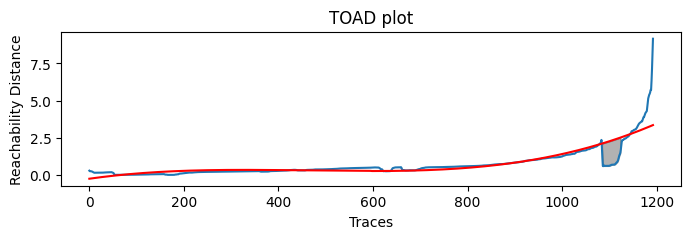

F1-Score for minpts value 15:


0.8863636363636364

Precision-Score for minpts value 15:


1.0

Precision-Score for minpts value 15:


0.7959183673469388

['48434',
 '48456',
 '48510',
 '49053',
 '49058',
 '49041',
 '48980',
 '49116',
 '48507',
 '48500',
 '48295',
 '48338',
 '49079',
 '48605',
 '48466',
 '49040',
 '48358',
 '48514',
 '48427',
 '48310',
 '48558',
 '49051',
 '48348',
 '48252',
 '48596',
 '48594',
 '48652',
 '48426',
 '49000',
 '48349',
 '48470',
 '48525',
 '48415',
 '48331',
 '48275',
 '48582',
 '48437',
 '48671',
 '49009']

Number of traces:  1199
Number of relations:  85


C:\Users\alper\AppData\Local\Temp\ipykernel_9928\2836719356.py:164: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xs = np.arange(int(properties["left_ips"]), int(properties["right_ips"]), 1)
C:\Users\alper\AppData\Local\Temp\ipykernel_9928\2836719356.py:165: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax1.fill_between(xs, reach_smoothed[int(properties["left_ips"]):int(properties["right_ips"])], yhat[int(properties["left_ips"]):int(properties["right_ips"])], color='00', alpha=0.3)


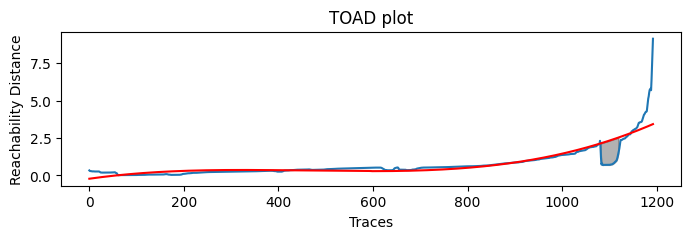

F1-Score for minpts value 20:


0.8735632183908046

Precision-Score for minpts value 20:


1.0

Precision-Score for minpts value 20:


0.7755102040816326

['48434',
 '48456',
 '48510',
 '49053',
 '49058',
 '49041',
 '48980',
 '49116',
 '48507',
 '48500',
 '48295',
 '48338',
 '49079',
 '48605',
 '48466',
 '49040',
 '48358',
 '48514',
 '48427',
 '48310',
 '48252',
 '48558',
 '49051',
 '48348',
 '48652',
 '48426',
 '48596',
 '49000',
 '48594',
 '48525',
 '48470',
 '48349',
 '48415',
 '48331',
 '48275',
 '48582',
 '48437',
 '48671']

Number of traces:  1199
Number of relations:  85


C:\Users\alper\AppData\Local\Temp\ipykernel_9928\2836719356.py:164: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xs = np.arange(int(properties["left_ips"]), int(properties["right_ips"]), 1)
C:\Users\alper\AppData\Local\Temp\ipykernel_9928\2836719356.py:165: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax1.fill_between(xs, reach_smoothed[int(properties["left_ips"]):int(properties["right_ips"])], yhat[int(properties["left_ips"]):int(properties["right_ips"])], color='00', alpha=0.3)


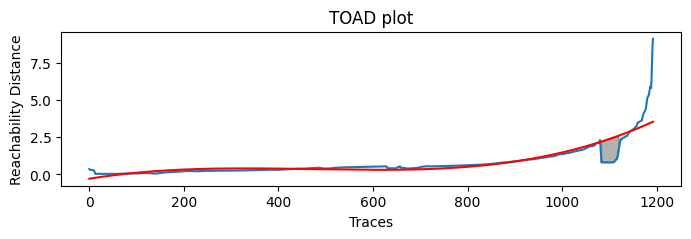

F1-Score for minpts value 25:


0.8604651162790697

Precision-Score for minpts value 25:


1.0

Precision-Score for minpts value 25:


0.7551020408163265

['48456',
 '49053',
 '49058',
 '49116',
 '48507',
 '48500',
 '49041',
 '48510',
 '48558',
 '49079',
 '48980',
 '49051',
 '48605',
 '48295',
 '48348',
 '48358',
 '48466',
 '48338',
 '49040',
 '48252',
 '48514',
 '48652',
 '48596',
 '48427',
 '48310',
 '49000',
 '48525',
 '48426',
 '48594',
 '48470',
 '48415',
 '48349',
 '48275',
 '48331',
 '48582',
 '48437',
 '48671']

AUC ROC Score for minPTS [5, 15, 20, 25, 30, 35, 40, 45]: is: 


np.float64(0.8979591836734694)

AUC PR Score for minPTS [5, 15, 20, 25, 30, 35, 40, 45]: is: 


np.float64(0.8042586509165801)

Mean F1-Score for minPTS [5, 15, 20, 25, 30, 35, 40, 45]: is: 


np.float64(0.8734441447352432)

In [29]:
ansatz3_bpi15_10results = metrics('BPI15_1_10h_10p_6act.jsonocel', 'BPI15_1_10h_10p_anomalous_app_objects.txt', 10, 1.2)

In [ ]:
ansatz3_bpi15_20results = metrics('BPI15_1_20h_20p_6act.jsonocel', 'BPIC15_1_20h_20p_6act_anomalous_app_objects.txt', 10, 1.2)